In [1]:
import time
import torch
from torch_geometric.loader import DataLoader
from tqdm import trange, tqdm
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))


import tomli
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker

from cutlass import *
from rbfConv import *
from tqdm.notebook import tqdm

In [2]:
nx = 2
ny = 4
fin = 6
fout = 8

ni = 16
nj = 8

support = 0.25

positions_i = torch.rand((ni,2)).type(torch.float64)#fluidPositions[:128,:]
positions_j = torch.rand((nj,2)).type(torch.float64)#fluidPositions[:64,:]

fluidFeatures_i = torch.rand((positions_i.shape[0], fin)).type(torch.float64)
fluidFeatures_j = torch.rand((positions_j.shape[0], fin)).type(torch.float64)
fluidFeatures_i.requires_grad = False
fluidFeatures_j.requires_grad = False

fi, fj = radius(positions_j, positions_i, support, max_num_neighbors = 256, batch_x = None, batch_y = None)

fluidEdgeIndex = torch.stack([fi, fj], dim = 0)
fluidEdgeLengths = (positions_j[fluidEdgeIndex[1]] - positions_i[fluidEdgeIndex[0]])/support

weight = Parameter(torch.Tensor(nx,ny, fin, fout))
torch.nn.init.xavier_normal_(weight);
# with torch.no_grad():
#     weight[:,:,:,:] = 1

# debugPrint(fluidFeatures)
#         debugPrint(torch.min(fluidEdgeLengths))

convolution = cutlass.apply

# out = convolution(fluidEdgeIndex, fluidFeatures, fluidEdgeLengths, None, weight, 
#                                             fluidFeatures.shape[0], 0,
#                                         [nx, ny] , ['linear', 'linear'], [False, False], 
#                                         1,1)

# debugPrint(out)




# globalNumerical, globalAnalytical = None, None

# gradcheck(convOp, weight.type(torch.float64))

windowFn = lambda r: torch.ones_like(r) * 2# torch.clamp(torch.pow(1. - r, 4) * (1.0 + 4.0 * r), min = 0)
windowFn = lambda r:torch.clamp(torch.pow(1. - r, 4) * (1.0 + 4.0 * r), min = 0)


In [3]:
debugPrint(fi.shape)

fi.shape [Size] = torch.Size([19])


In [4]:
from gradcheck import *

In [5]:
weight.requires_grad = False
fluidFeatures_i.requires_grad = False
fluidFeatures_j.requires_grad = False

In [6]:
convOp = lambda x: convolution(fluidEdgeIndex, fluidFeatures_i, x, fluidEdgeLengths.type(torch.float64), windowFn(torch.linalg.norm(fluidEdgeLengths,dim=1).type(torch.float64)), weight.type(torch.float64), 
                                            fluidFeatures_i.shape[0], 0,
                                        [nx, ny] , ['linear', 'linear'], [False, False], 
                                        1,1)

debugPrint(torch.max(fluidEdgeIndex[0]))
debugPrint(torch.max(fluidEdgeIndex[1]))

result = convOp(fluidFeatures_j.type(torch.float64))
# debugPrint(result)
debugPrint(result.dtype)
debugPrint(result.shape)

weight.requires_grad = False
fluidFeatures_i.requires_grad = False
fluidFeatures_j.requires_grad = True

debugPrint(gradcheck(convOp, fluidFeatures_j.type(torch.float64)))

weight.requires_grad = True
fluidFeatures_i.requires_grad = False
fluidFeatures_j.requires_grad = True

debugPrint(gradcheck(convOp, fluidFeatures_j.type(torch.float64)))

torch.max(fluidEdgeIndex[0]) [Tensor] = 15
torch.max(fluidEdgeIndex[1]) [Tensor] = 7
result.dtype [dtype] = torch.float64
result.shape [Size] = torch.Size([16, 8])
gradcheck(convOp, fluidFeatures_j.type(torch.float64)) [bool] = True
gradcheck(convOp, fluidFeatures_j.type(torch.float64)) [bool] = True


In [7]:

convOp = lambda x: convolution(fluidEdgeIndex, fluidFeatures_i.type(torch.float64), fluidFeatures_j, fluidEdgeLengths.type(torch.float64), None, x, 
                                            fluidFeatures_i.shape[0], 0,
                                        [nx, ny] , ['linear', 'linear'], [False, False], 
                                        1,1)

gradcheck(convOp, weight.type(torch.float64))

weight.requires_grad = True
fluidFeatures_i.requires_grad = False
fluidFeatures_j.requires_grad = False

debugPrint(gradcheck(convOp, weight.type(torch.float64)))

weight.requires_grad = True
fluidFeatures_i.requires_grad = False
fluidFeatures_j.requires_grad = True

debugPrint(gradcheck(convOp, weight.type(torch.float64)))

gradcheck(convOp, weight.type(torch.float64)) [bool] = True
gradcheck(convOp, weight.type(torch.float64)) [bool] = True


In [8]:

from gradcheck import globalNumerical, globalAnalytical

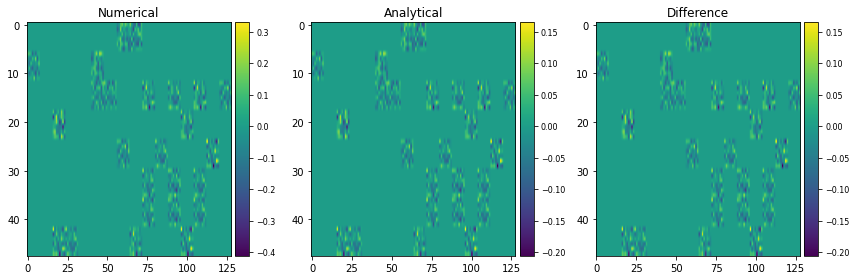

In [37]:
# This is only possible if there was an error
fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)

axis[0,0].set_title('Numerical')
im = axis[0,0].imshow(globalNumerical)
ax1_divider = make_axes_locatable(axis[0,0])
axis[0,0].axis('auto')
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
numCbar = fig.colorbar(im, cax=cax1,orientation='vertical')
numCbar.ax.tick_params(labelsize=8) 

axis[0,1].set_title('Analytical')
im = axis[0,1].imshow(globalAnalytical)
ax1_divider = make_axes_locatable(axis[0,1])
axis[0,1].axis('auto')
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
numCbar = fig.colorbar(im, cax=cax1,orientation='vertical')
numCbar.ax.tick_params(labelsize=8) 

axis[0,2].set_title('Difference')
im = axis[0,2].imshow(globalNumerical - globalAnalytical)
ax1_divider = make_axes_locatable(axis[0,2])
axis[0,2].axis('auto')
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
numCbar = fig.colorbar(im, cax=cax1,orientation='vertical')
numCbar.ax.tick_params(labelsize=8) 

fig.tight_layout()
